Nombre de features : 74
Nombre d'observations : 49

RÉSULTATS DES MODÈLES ML

Random Forest:
  Tracking Error (train): 1.3239%
  Tracking Error (test):  1.7178%

PONDÉRATIONS SECTORIELLES (Random Forest)
MSCI ACWI IMI Consumer Discretionary Index: 0.1567
MSCI ACWI IMI Materials Index: 0.1144
MSCI ACWI IMI Industrials Index: 0.1136
MSCI ACWI IMI Communication Services Index: 0.1108
MSCI ACWI IMI Information Technology Index: 0.1020
MSCI ACWI IMI Financials Index: 0.1008
MSCI ACWI IMI Real Estate Index: 0.0893
MSCI ACWI IMI Consumer Staples Index: 0.0788
MSCI ACWI IMI Utilities Index: 0.0629
MSCI ACWI IMI Healthcare Index: 0.0604
MSCI ACWI IMI Energy Index: 0.0104


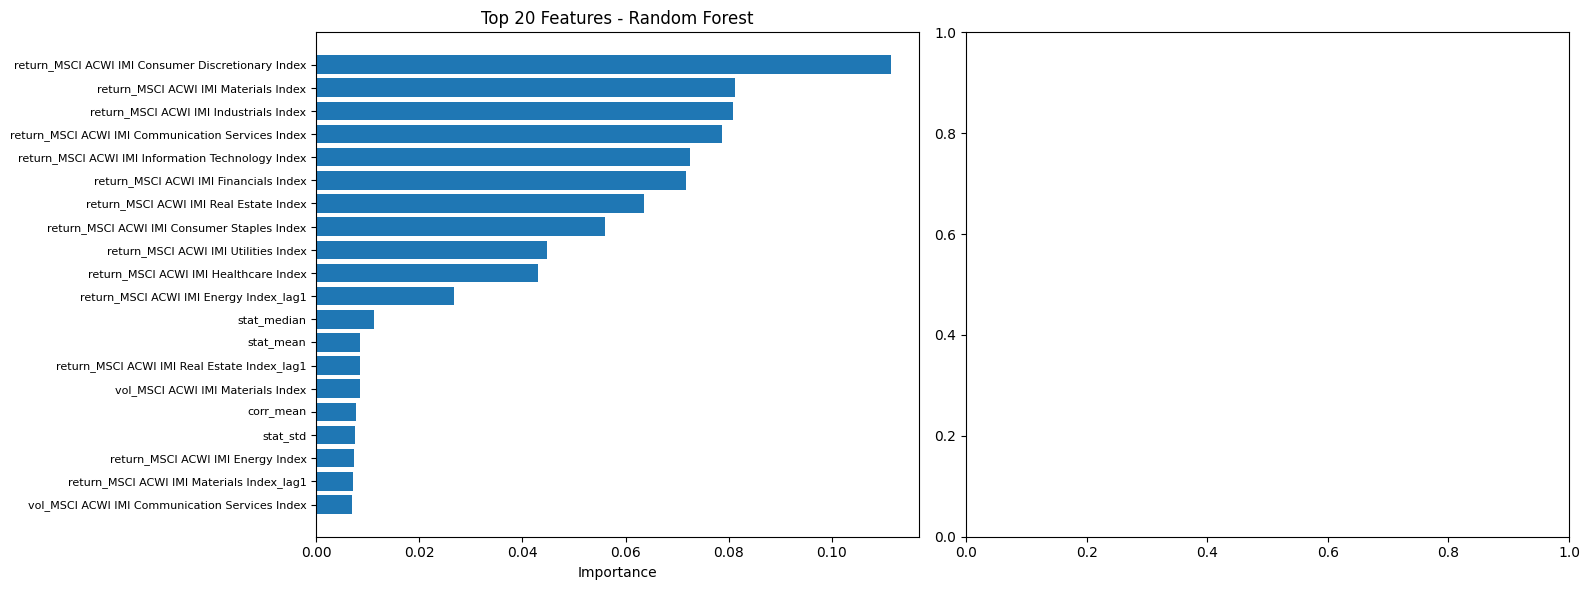

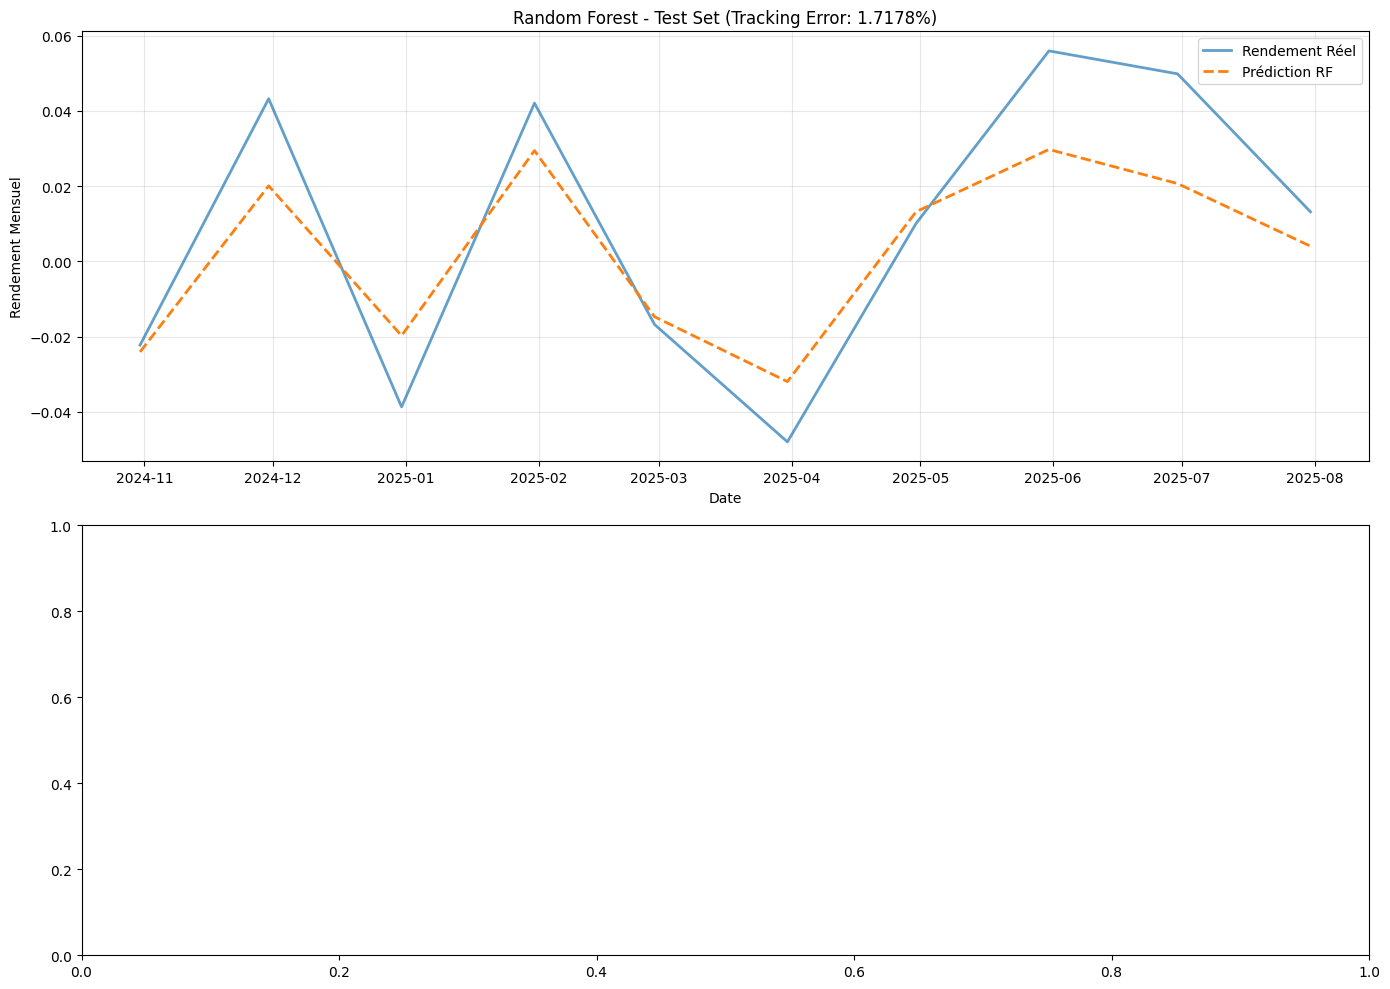

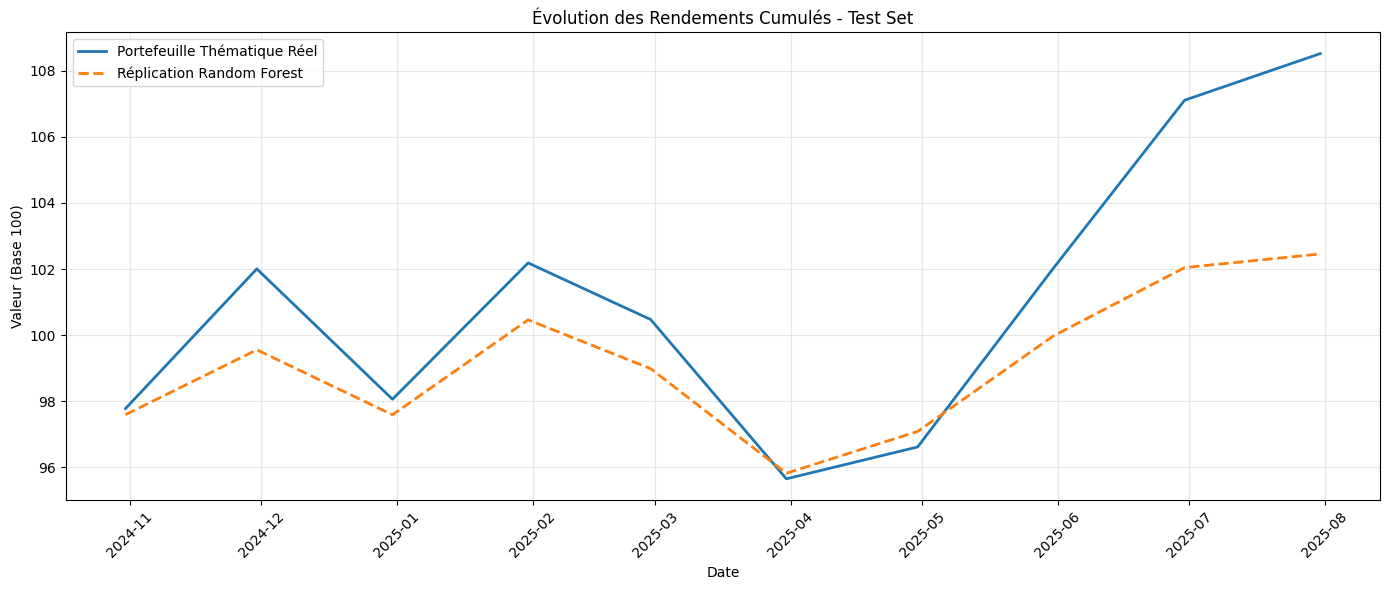

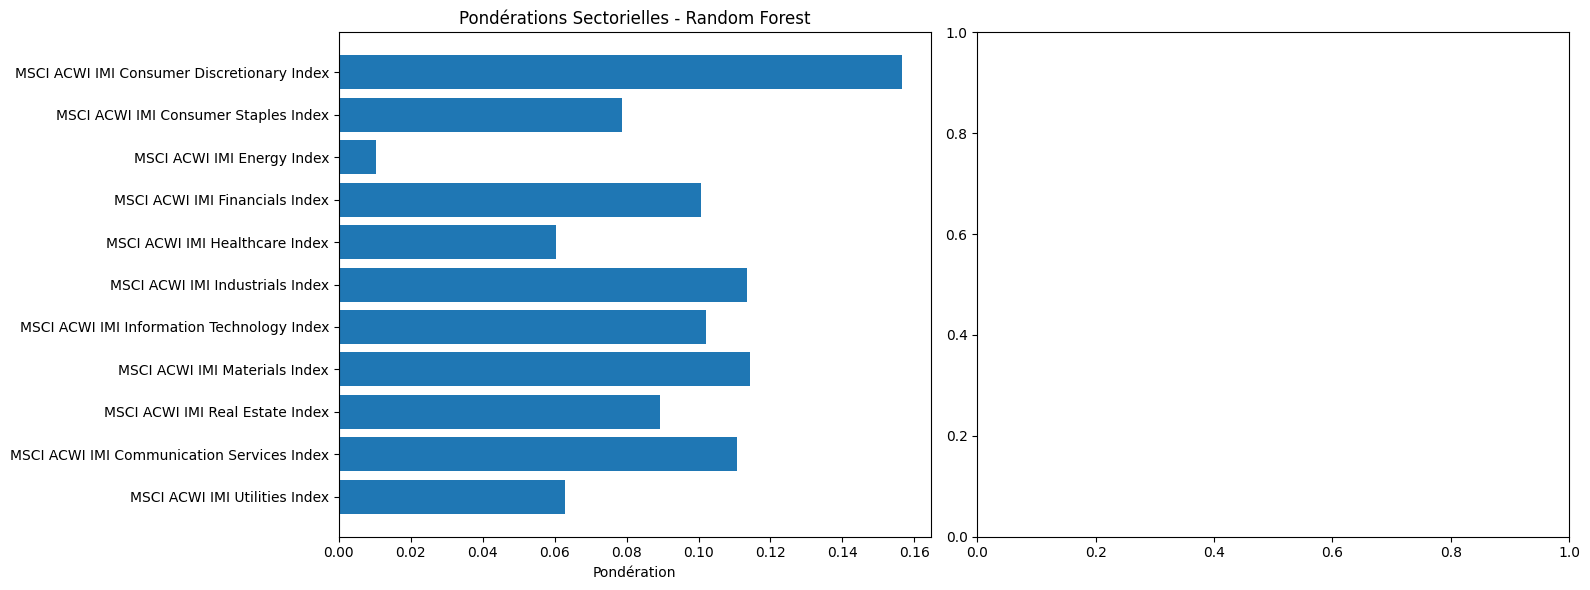


WALK-FORWARD VALIDATION (XGBoost, Sliding Window)
Tracking Error (walk-forward): 1.9427%


In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from portfolio_rebalancing import load_returns_data

# =============================================================================
# 1. CHARGEMENT ET PRÉPARATION DES DONNÉES
# =============================================================================

thematic_file = "msci_acwi_imi_thematics_daily_returns_202007_202508.csv"
sector_file = "msci_acwi_imi_sectors_daily_returns_202007_202508.csv"

thematic_df = load_returns_data(thematic_file)
sector_df = load_returns_data(sector_file)

# Supprimer les colonnes thématiques avec valeurs manquantes en début de série
debut_date = thematic_df['date'].min()
drop_cols = [
    col for col in thematic_df.columns if col != 'date'
    and pd.isna(thematic_df.loc[thematic_df['date'] == debut_date, col]).any()
]
thematic_df = thematic_df.drop(columns=drop_cols)

# Composition mensuelle
def compose_monthly_returns(df):
    df = df.set_index('date')
    return ((1 + df).resample('ME').prod() - 1).reset_index()

thematic_m = compose_monthly_returns(thematic_df)
sector_m = compose_monthly_returns(sector_df)

# Drop la dernière ligne si mois incomplet
thematic_m = thematic_m.iloc[:-1, :]
sector_m = sector_m.iloc[:-1, :]

# =============================================================================
# 2. CONSTRUCTION DES FEATURES
# =============================================================================

def create_ml_features(sector_df, thematic_df, lags=[1, 2, 3, 6], vol_window=12):
    """
    Crée un jeu de données enrichi avec features pour l'apprentissage automatique.
    
    Features incluses:
    - Rendements sectoriels courants
    - Rendements sectoriels laggés (1, 2, 3, 6 mois)
    - Volatilités roulantes des secteurs
    - Corrélations roulantes entre secteurs
    - Statistiques agrégées (moyenne, écart-type, min, max)
    """
    sector_cols = [col for col in sector_df.columns if col != 'date']
    thematic_cols = [col for col in thematic_df.columns if col != 'date']
    
    # Aligner les dates
    common_dates = sector_df['date'].values
    sector_data = sector_df[sector_cols].values
    thematic_data = thematic_df[thematic_cols].values
    
    # Target : rendement moyen thématique
    y = thematic_data.mean(axis=1)
    
    # Liste pour stocker les features
    features_list = []
    
    for t in range(vol_window, len(common_dates)):
        # Features de base : rendements sectoriels courants
        current_returns = sector_data[t, :]
        
        # Features laggées : rendements sectoriels aux mois précédents
        lagged_features = []
        for lag in lags:
            if t >= lag:
                lagged_features.extend(sector_data[t - lag, :])
            else:
                lagged_features.extend([np.nan] * len(sector_cols))
        
        # Volatilités roulantes (écart-type sur fenêtre glissante)
        vol_features = []
        for sector_idx in range(len(sector_cols)):
            window_returns = sector_data[t - vol_window:t, sector_idx]
            vol = np.std(window_returns)
            vol_features.append(vol)
        
        # Corrélations roulantes entre secteurs (moyenne des corrélations)
        corr_features = []
        window_data = sector_data[t - vol_window:t, :]
        if len(window_data) > 1:
            corr_matrix = np.corrcoef(window_data.T)
            # Moyenne des corrélations (hors diagonale)
            mean_corr = (np.sum(corr_matrix) - np.trace(corr_matrix)) / (len(sector_cols) * (len(sector_cols) - 1))
            corr_features.append(mean_corr)
            # Corrélations maximales et minimales
            mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
            upper_tri = corr_matrix[mask]
            corr_features.append(np.max(upper_tri))
            corr_features.append(np.min(upper_tri))
        else:
            corr_features.extend([np.nan, np.nan, np.nan])
        
        # Statistiques agrégées sur la fenêtre
        window_stats = [
            np.mean(window_data),
            np.std(window_data),
            np.min(window_data),
            np.max(window_data),
            np.median(window_data)
        ]
        
        # Combiner toutes les features
        feature_vector = np.concatenate([
            current_returns,          # N secteurs
            lagged_features,         # N * len(lags)
            vol_features,            # N secteurs
            corr_features,           # 3 features de corrélation
            window_stats             # 5 statistiques
        ])
        
        features_list.append(feature_vector)
    
    # Créer DataFrame de features
    feature_names = (
        [f"return_{col}" for col in sector_cols] +
        [f"return_{col}_lag{lag}" for lag in lags for col in sector_cols] +
        [f"vol_{col}" for col in sector_cols] +
        ["corr_mean", "corr_max", "corr_min"] +
        ["stat_mean", "stat_std", "stat_min", "stat_max", "stat_median"]
    )
    
    X_df = pd.DataFrame(features_list, columns=feature_names)
    y_series = pd.Series(y[vol_window:], name='thematic_return')
    dates = common_dates[vol_window:]
    
    return X_df, y_series, dates

# Créer les features
X_features, y_target, dates = create_ml_features(sector_m, thematic_m)

# Gérer les valeurs manquantes (imputation par la moyenne)
X_features = X_features.fillna(X_features.mean())

print(f"Nombre de features : {X_features.shape[1]}")
print(f"Nombre d'observations : {X_features.shape[0]}")

# =============================================================================
# 3. SPLIT TEMPOREL ET STANDARDISATION
# =============================================================================

# Split temporel (80%/20%)
split_idx = int(len(X_features) * 0.8)

X_train = X_features.iloc[:split_idx]
X_test = X_features.iloc[split_idx:]
y_train = y_target.iloc[:split_idx]
y_test = y_target.iloc[split_idx:]
dates_train = dates[:split_idx]
dates_test = dates[split_idx:]

# Standardisation
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# =============================================================================
# 4. ENTRAÎNEMENT DES MODÈLES ML
# =============================================================================

# Random Forest
rf_model = RandomForestRegressor(
    n_estimators=300,  # Augmenter le nombre d'arbres pour compenser
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_model.fit(X_train_scaled, y_train)
y_pred_rf_train = rf_model.predict(X_train_scaled)
y_pred_rf_test = rf_model.predict(X_test_scaled)


# =============================================================================
# 5. EXTRACTION DES IMPORTANCES ET CALCUL DES PONDÉRATIONS SECTORIELLES
# =============================================================================

def extract_sector_weights_from_importances(model, feature_names, sector_names):
    """
    Extrait les pondérations sectorielles à partir des importances des features.
    
    Stratégie:
    1. Identifier les features liées à chaque secteur (rendements courants)
    2. Agréger les importances pour chaque secteur
    3. Normaliser pour obtenir des pondérations qui somment à 1
    """
    importances = model.feature_importances_
    
    # Créer un dictionnaire pour stocker les importances par secteur
    sector_importances = {sector: 0.0 for sector in sector_names}
    
    # Parcourir les features de rendements courants uniquement
    for i, feature_name in enumerate(feature_names):
        if feature_name.startswith('return_') and not '_lag' in feature_name:
            # Extraire le nom du secteur depuis le nom de la feature
            sector_name = feature_name.replace('return_', '')
            if sector_name in sector_importances:
                sector_importances[sector_name] += importances[i]
    
    # Normaliser pour obtenir des pondérations
    total_importance = sum(sector_importances.values())
    if total_importance > 0:
        sector_weights = {sector: imp / total_importance 
                         for sector, imp in sector_importances.items()}
    else:
        sector_weights = {sector: 1.0 / len(sector_names) 
                         for sector in sector_names}
    
    return sector_weights

# Noms des secteurs (colonnes du dataframe original)
sector_cols = [col for col in sector_m.columns if col != 'date']

# Extraire les pondérations pour Random Forest
rf_weights = extract_sector_weights_from_importances(
    rf_model, X_train_scaled.columns, sector_cols
)

# =============================================================================
# 6. ÉVALUATION ET MÉTRIQUES
# =============================================================================

def tracking_error(y_true, y_pred):
    """Calcule le tracking error (RMSE)"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Calculer les tracking errors
te_rf_train = tracking_error(y_train, y_pred_rf_train)
te_rf_test = tracking_error(y_test, y_pred_rf_test)

print("\n" + "="*70)
print("RÉSULTATS DES MODÈLES ML")
print("="*70)
print(f"\nRandom Forest:")
print(f"  Tracking Error (train): {te_rf_train:.4%}")
print(f"  Tracking Error (test):  {te_rf_test:.4%}")

print("\n" + "="*70)
print("PONDÉRATIONS SECTORIELLES (Random Forest)")
print("="*70)
for sector, weight in sorted(rf_weights.items(), key=lambda x: x[1], reverse=True):
    print(f"{sector}: {weight:.4f}")

# =============================================================================
# 7. VISUALISATIONS
# =============================================================================

# 7.1 Importances des features (top 20)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
rf_importances_df = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

axes[0].barh(range(len(rf_importances_df)), rf_importances_df['importance'])
axes[0].set_yticks(range(len(rf_importances_df)))
axes[0].set_yticklabels(rf_importances_df['feature'], fontsize=8)
axes[0].set_xlabel('Importance')
axes[0].set_title('Top 20 Features - Random Forest')
axes[0].invert_yaxis()


plt.tight_layout()
plt.show()

# 7.2 Comparaison des prédictions vs réels (test set)
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Random Forest
axes[0].plot(dates_test, y_test.values, label='Rendement Réel', lw=2, alpha=0.7)
axes[0].plot(dates_test, y_pred_rf_test, label='Prédiction RF', lw=2, linestyle='--')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Rendement Mensuel')
axes[0].set_title(f'Random Forest - Test Set (Tracking Error: {te_rf_test:.4%})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

# 7.3 Rendements cumulés base 100 (test set)
fig, ax = plt.subplots(figsize=(14, 6))

cum_real = 100 * np.cumprod(1 + y_test.values)
cum_rf = 100 * np.cumprod(1 + y_pred_rf_test)

ax.plot(dates_test, cum_real, label='Portefeuille Thématique Réel', lw=2)
ax.plot(dates_test, cum_rf, label='Réplication Random Forest', lw=2, linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Valeur (Base 100)')
ax.set_title('Évolution des Rendements Cumulés - Test Set')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7.4 Comparaison des pondérations sectorielles
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
rf_sectors = list(rf_weights.keys())
rf_weights_vals = list(rf_weights.values())
axes[0].barh(rf_sectors, rf_weights_vals)
axes[0].set_xlabel('Pondération')
axes[0].set_title('Pondérations Sectorielles - Random Forest')
axes[0].invert_yaxis()

plt.tight_layout()
plt.show()

# =============================================================================
# 8. VERSION AVEC WALK-FORWARD VALIDATION (rebalancement mensuel)
# =============================================================================

def walk_forward_ml_rebalancing(X_features, y_target, dates, 
                                initial_train_size, window_size=24,
                                model_type='rf'):
    """
    Walk-forward validation avec rebalancement mensuel pour les modèles ML.
    
    Args:
        X_features: DataFrame des features
        y_target: Series des rendements cibles
        dates: Array des dates
        initial_train_size: Taille initiale de l'entraînement
        window_size: Taille de la fenêtre glissante (None pour expanding window)
        model_type: 'rf' pour Random Forest, 'xgb' pour XGBoost
    """
    n_months = len(y_target)
    predicted_returns = []
    all_weights = []
    
    scaler = StandardScaler()
    
    for t in range(initial_train_size, n_months):
        # Fenêtre d'entraînement
        if window_size is None:
            # Expanding window
            train_start = 0
        else:
            # Sliding window
            train_start = max(0, t - window_size)
        
        X_train = X_features.iloc[train_start:t]
        y_train = y_target.iloc[train_start:t]
        
        # Standardisation
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_features.iloc[t:t+1])
        
        # Entraînement du modèle
        if model_type == 'rf':
            model = RandomForestRegressor(
                n_estimators=100,
                max_depth=10,
                min_samples_split=5,
                random_state=42,
                n_jobs=-1
            )
        else:  # xgb
            model = XGBRegressor(
                n_estimators=100,
                max_depth=6,
                learning_rate=0.05,
                random_state=42,
                n_jobs=-1
            )
        
        model.fit(X_train_scaled, y_train)
        
        # Prédiction
        y_pred_t = model.predict(X_test_scaled)[0]
        predicted_returns.append(y_pred_t)
        
        # Extraire les pondérations sectorielles
        sector_cols = [col for col in sector_m.columns if col != 'date']
        weights = extract_sector_weights_from_importances(
            model, X_features.columns, sector_cols
        )
        all_weights.append(weights)
    
    predicted_returns = np.array(predicted_returns)
    actual_returns = y_target.iloc[initial_train_size:].values
    tracking_error = np.sqrt(mean_squared_error(actual_returns, predicted_returns))
    
    return predicted_returns, actual_returns, tracking_error, all_weights

# Exécuter walk-forward pour XGBoost
print("\n" + "="*70)
print("WALK-FORWARD VALIDATION (XGBoost, Sliding Window)")
print("="*70)

pred_wf, actual_wf, te_wf, weights_wf = walk_forward_ml_rebalancing(
    X_features, y_target, dates,
    initial_train_size=split_idx,
    window_size=18,
    model_type='rf'
)

print(f"Tracking Error (walk-forward): {te_wf:.4%}")



DIAGNOSTIC DE CORRÉLATION
Nombre de features: 74
Paires très corrélées (r>0.7): 193
Groupes de features corrélées: 31

Top 10 paires les plus corrélées:
  vol_MSCI ACWI IMI Industrials Index      <-> stat_std                                 : 0.953
  vol_MSCI ACWI IMI Consumer Discretionary <-> vol_MSCI ACWI IMI Information Technology : 0.944
  vol_MSCI ACWI IMI Materials Index        <-> stat_std                                 : 0.938
  vol_MSCI ACWI IMI Information Technology <-> stat_std                                 : 0.937
  stat_mean                                <-> stat_median                              : 0.932
  vol_MSCI ACWI IMI Consumer Discretionary <-> vol_MSCI ACWI IMI Materials Index        : 0.919
  vol_MSCI ACWI IMI Industrials Index      <-> vol_MSCI ACWI IMI Materials Index        : 0.917
  vol_MSCI ACWI IMI Industrials Index      <-> vol_MSCI ACWI IMI Information Technology : 0.913
  vol_MSCI ACWI IMI Consumer Discretionary <-> vol_MSCI ACWI IMI Communication

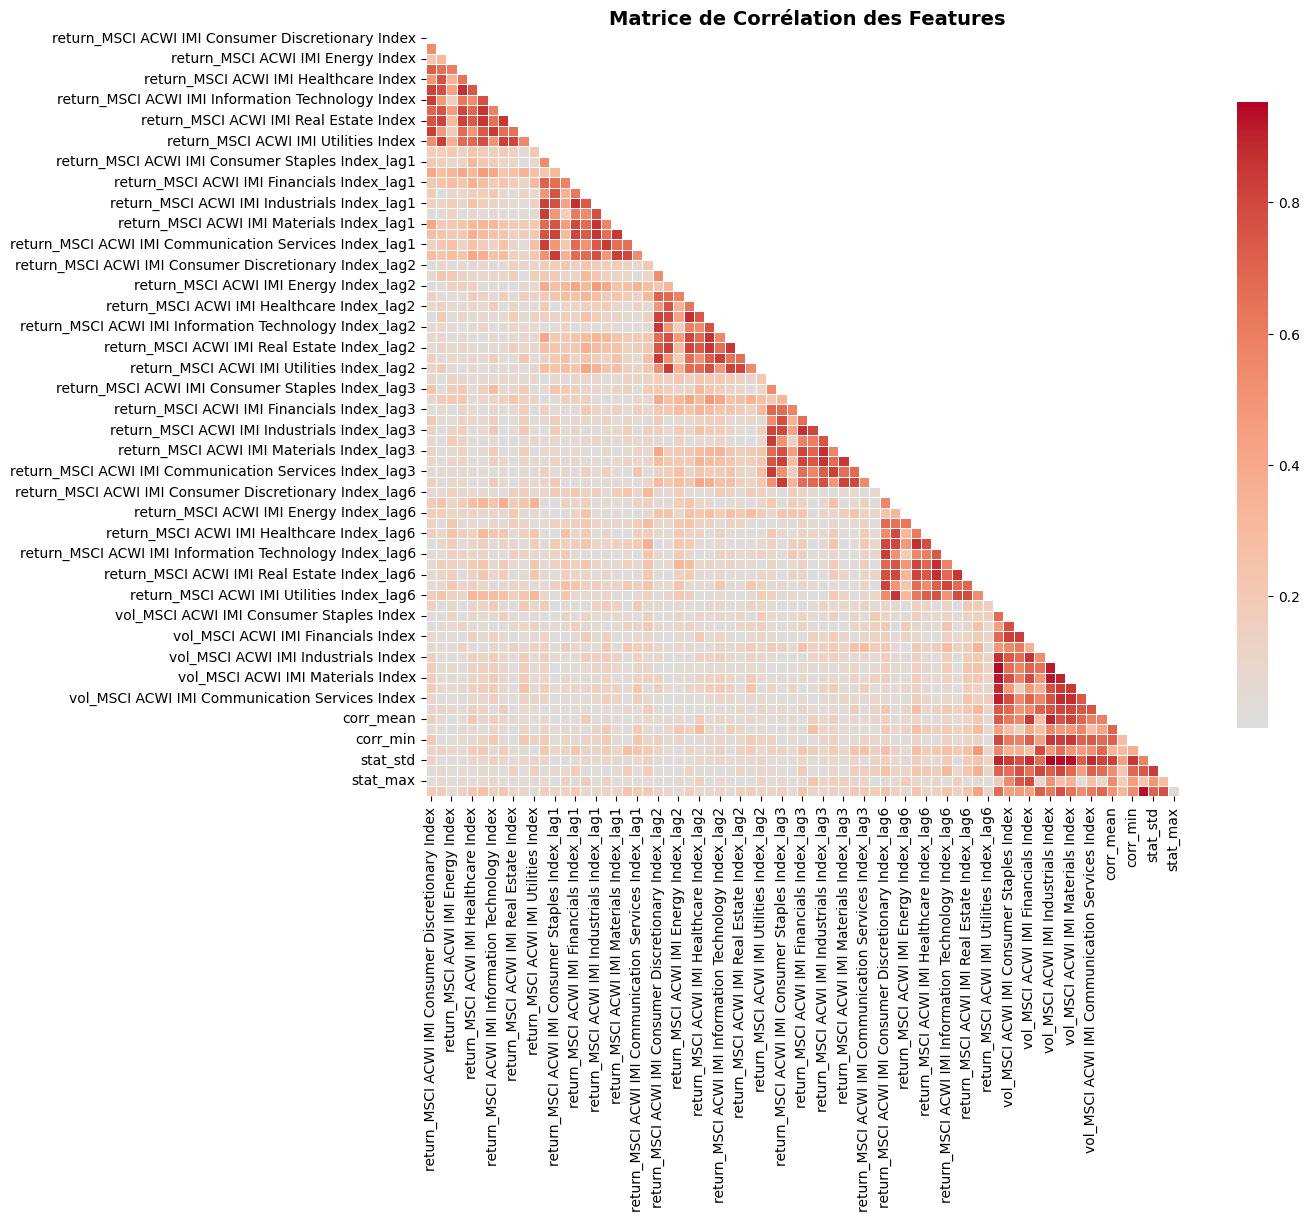

COMPARAISON DES STRATÉGIES DE GESTION DE CORRÉLATION

1. Random Forest Standard (baseline)...
   Tracking Error: 1.8789% (74 features)

2. Random Forest avec max_features='sqrt' (recommandé)...
   Tracking Error: 1.7637% (74 features)

3. Features sélectionnées (Mutual Information)...
   Tracking Error: 1.5467% (30 features sélectionnées)

4. Features PCA (95% variance expliquée)...
Nombre de composantes pour 95.0% variance: 19
   Tracking Error: 2.5987% (19 composantes)

5. Features décorrélées (suppression corr > 0.85)...
   Tracking Error: 2.4159% (40 features, 34 supprimées)

RÉSUMÉ
standard       : TE=1.8789%, Features=74
corr_robust    : TE=1.7637%, Features=74
selected       : TE=1.5467%, Features=30
pca            : TE=2.5987%, Features=19
decorrelated   : TE=2.4159%, Features=40

✓ Meilleure méthode: selected (TE=1.5467%)

Utilisation de la méthode: selected

Calcul de l'importance par permutation (plus robuste à la corrélation)...

Top 10 features par importance de permutatio

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from portfolio_rebalancing import load_returns_data

# =============================================================================
# DIAGNOSTIC DE CORRÉLATION
# =============================================================================

def analyze_feature_correlation(X_features, threshold=0.7):
    """
    Analyse les corrélations entre features et identifie les groupes corrélés.
    
    Returns:
        correlation_matrix: Matrice de corrélation
        high_corr_pairs: Paires de features très corrélées
        feature_groups: Groupes de features corrélées
    """
    corr_matrix = X_features.corr().abs()
    
    # Identifier les paires très corrélées
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                high_corr_pairs.append((
                    corr_matrix.columns[i],
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i, j]
                ))
    
    # Grouper les features corrélées
    feature_groups = []
    processed = set()
    
    for feat1, feat2, corr_val in high_corr_pairs:
        if feat1 not in processed and feat2 not in processed:
            group = [feat1, feat2]
            processed.add(feat1)
            processed.add(feat2)
            feature_groups.append(group)
    
    return corr_matrix, high_corr_pairs, feature_groups


def plot_correlation_analysis(corr_matrix, figsize=(14, 12)):
    """Visualise la matrice de corrélation."""
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', 
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Matrice de Corrélation des Features', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# =============================================================================
# TECHNIQUE 1: RÉDUCTION DE CORRÉLATION PAR PCA (recommandé)
# =============================================================================

def create_pca_features(X_train, X_test, n_components=None, variance_explained=0.95):
    """
    Crée des features PCA pour réduire la corrélation.
    
    Args:
        n_components: Nombre fixe de composantes (None = variance expliquée)
        variance_explained: Proportion de variance à expliquer (si n_components=None)
    
    Returns:
        X_train_pca, X_test_pca, pca_model, explained_variance
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    if n_components is None:
        # Déterminer le nombre de composantes pour expliquer variance_explained
        pca_temp = PCA()
        pca_temp.fit(X_train_scaled)
        cumsum_var = np.cumsum(pca_temp.explained_variance_ratio_)
        n_components = np.argmax(cumsum_var >= variance_explained) + 1
        print(f"Nombre de composantes pour {variance_explained*100:.1f}% variance: {n_components}")
    
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    explained_var = pca.explained_variance_ratio_
    
    return X_train_pca, X_test_pca, pca, explained_var


# =============================================================================
# TECHNIQUE 2: SÉLECTION DE FEATURES (basée sur corrélation)
# =============================================================================

def remove_highly_correlated_features(X_features, threshold=0.85):
    """
    Supprime les features hautement corrélées, en gardant celle avec la meilleure corrélation avec y.
    
    Args:
        X_features: DataFrame des features
        threshold: Seuil de corrélation pour suppression
    
    Returns:
        X_filtered: Features filtrées
        removed_features: Liste des features supprimées
    """
    corr_matrix = X_features.corr().abs()
    
    # Trouver les paires corrélées
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    to_remove = set()
    for col in upper_triangle.columns:
        for idx in upper_triangle.index:
            if pd.notna(upper_triangle.loc[idx, col]) and upper_triangle.loc[idx, col] > threshold:
                # Garder la feature qui apparaît en premier (ou utiliser critère plus sophistiqué)
                to_remove.add(idx)
    
    X_filtered = X_features.drop(columns=list(to_remove))
    
    return X_filtered, list(to_remove)


def select_features_by_importance(X_train, y_train, X_test, n_features=None, method='mutual_info'):
    """
    Sélectionne les features les plus importantes en utilisant des métriques non-linéaires.
    
    Args:
        method: 'mutual_info' (recommandé pour RF) ou 'f_regression'
        n_features: Nombre de features à garder (None = top 50%)
    """
    if n_features is None:
        n_features = max(10, X_train.shape[1] // 2)
    
    if method == 'mutual_info':
        selector = SelectKBest(score_func=mutual_info_regression, k=n_features)
    else:
        selector = SelectKBest(score_func=f_regression, k=n_features)
    
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    selected_features = X_train.columns[selector.get_support()].tolist()
    
    return X_train_selected, X_test_selected, selector, selected_features


# =============================================================================
# TECHNIQUE 3: RANDOM FOREST AVEC PARAMÈTRES ADAPTÉS À LA CORRÉLATION
# =============================================================================

def create_correlation_robust_rf(n_estimators=300, max_features='sqrt', **kwargs):
    """
    Crée un Random Forest optimisé pour gérer la corrélation.
    
    Paramètres clés:
    - max_features='sqrt': Réduit la probabilité de sélectionner des features corrélées ensemble
    - max_depth: Limite la profondeur pour éviter le surapprentissage
    - min_samples_split: Augmente pour plus de robustesse
    """
    return RandomForestRegressor(
        n_estimators=n_estimators,
        max_features=max_features,  # Clé: sélection aléatoire réduit l'impact de la corrélation
        max_depth=15,
        min_samples_split=10,  # Augmenté pour robustesse
        min_samples_leaf=5,
        bootstrap=True,
        random_state=42,
        n_jobs=-1,
        **kwargs
    )


# =============================================================================
# TECHNIQUE 4: IMPORTANCE CORRIGÉE (pour l'interprétation)
# =============================================================================

def compute_permutation_importance_with_correlation(model, X_test, y_test, n_repeats=10):
    """
    Calcule l'importance par permutation (plus robuste à la corrélation).
    
    L'importance par permutation est moins biaisée par la corrélation que l'importance native.
    """
    from sklearn.inspection import permutation_importance
    
    perm_importance = permutation_importance(
        model, X_test, y_test,
        n_repeats=n_repeats,
        random_state=42,
        n_jobs=-1
    )
    
    return perm_importance


def compute_shapley_importance(model, X_train_sample):
    """
    Utilise SHAP pour obtenir des importances plus équitables avec corrélation.
    Nécessite: pip install shap
    """
    try:
        import shap
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_train_sample)
        
        # Importance globale par feature
        feature_importance = np.abs(shap_values).mean(axis=0)
        
        return feature_importance, shap_values
    except ImportError:
        print("Shap non disponible. Installez avec: pip install shap")
        return None, None


# =============================================================================
# COMPARAISON DES APPROCHES
# =============================================================================

def compare_correlation_strategies(X_train, X_test, y_train, y_test, sector_cols):
    """
    Compare différentes stratégies de gestion de la corrélation.
    """
    results = {}
    
    print("="*70)
    print("COMPARAISON DES STRATÉGIES DE GESTION DE CORRÉLATION")
    print("="*70)
    
    # 1. Baseline: Random Forest standard
    print("\n1. Random Forest Standard (baseline)...")
    rf_standard = RandomForestRegressor(
        n_estimators=300, max_depth=15, random_state=42, n_jobs=-1
    )
    rf_standard.fit(X_train, y_train)
    y_pred_standard = rf_standard.predict(X_test)
    te_standard = np.sqrt(mean_squared_error(y_test, y_pred_standard))
    results['standard'] = {
        'model': rf_standard,
        'te': te_standard,
        'features': X_train.shape[1]
    }
    print(f"   Tracking Error: {te_standard:.4%} ({X_train.shape[1]} features)")
    
    # 2. RF avec max_features réduit
    print("\n2. Random Forest avec max_features='sqrt' (recommandé)...")
    rf_corr_robust = create_correlation_robust_rf(n_estimators=300)
    rf_corr_robust.fit(X_train, y_train)
    y_pred_corr = rf_corr_robust.predict(X_test)
    te_corr = np.sqrt(mean_squared_error(y_test, y_pred_corr))
    results['corr_robust'] = {
        'model': rf_corr_robust,
        'te': te_corr,
        'features': X_train.shape[1]
    }
    print(f"   Tracking Error: {te_corr:.4%} ({X_train.shape[1]} features)")
    
    # 3. Features sélectionnées (mutual info)
    print("\n3. Features sélectionnées (Mutual Information)...")
    X_train_sel, X_test_sel, selector, sel_features = select_features_by_importance(
        pd.DataFrame(X_train), y_train, pd.DataFrame(X_test), n_features=30
    )
    # Stockage explicite X_test_sel dans le dictionnaire results pour réutilisation ultérieure
    rf_selected = create_correlation_robust_rf()
    rf_selected.fit(X_train_sel, y_train)
    y_pred_sel = rf_selected.predict(X_test_sel)
    te_sel = np.sqrt(mean_squared_error(y_test, y_pred_sel))
    results['selected'] = {
        'model': rf_selected,
        'te': te_sel,
        'features': len(sel_features),
        'selected_features': sel_features,
        'X_test_selected': X_test_sel     # <-- Stocke X_test_sel ici
    }
    print(f"   Tracking Error: {te_sel:.4%} ({len(sel_features)} features sélectionnées)")
    
    # 4. PCA (95% variance)
    print("\n4. Features PCA (95% variance expliquée)...")
    X_train_pca, X_test_pca, pca, explained_var = create_pca_features(
        pd.DataFrame(X_train), pd.DataFrame(X_test), variance_explained=0.95
    )
    rf_pca = create_correlation_robust_rf()
    rf_pca.fit(X_train_pca, y_train)
    y_pred_pca = rf_pca.predict(X_test_pca)
    te_pca = np.sqrt(mean_squared_error(y_test, y_pred_pca))
    results['pca'] = {
        'model': rf_pca,
        'pca': pca,
        'te': te_pca,
        'features': X_train_pca.shape[1],
        'explained_var': explained_var,
        'X_test_pca': X_test_pca         # <-- Stocke X_test_pca ici pour usage ultérieur
    }
    print(f"   Tracking Error: {te_pca:.4%} ({X_train_pca.shape[1]} composantes)")
    
    # 5. Features décorrélées (suppression haute corrélation)
    print("\n5. Features décorrélées (suppression corr > 0.85)...")
    X_train_decorr, removed = remove_highly_correlated_features(
        pd.DataFrame(X_train), threshold=0.85
    )
    X_test_decorr = pd.DataFrame(X_test).drop(columns=removed)
    rf_decorr = create_correlation_robust_rf()
    rf_decorr.fit(X_train_decorr, y_train)
    y_pred_decorr = rf_decorr.predict(X_test_decorr)
    te_decorr = np.sqrt(mean_squared_error(y_test, y_pred_decorr))
    results['decorrelated'] = {
        'model': rf_decorr,
        'te': te_decorr,
        'features': X_train_decorr.shape[1],
        'removed': removed,
        'X_test_decorr': X_test_decorr   # <-- Stocke X_test_decorr ici aussi
    }
    print(f"   Tracking Error: {te_decorr:.4%} ({X_train_decorr.shape[1]} features, {len(removed)} supprimées)")
    
    # Résumé
    print("\n" + "="*70)
    print("RÉSUMÉ")
    print("="*70)
    for name, res in results.items():
        print(f"{name:15s}: TE={res['te']:.4%}, Features={res['features']}")
    
    best_method = min(results.items(), key=lambda x: x[1]['te'])
    print(f"\n✓ Meilleure méthode: {best_method[0]} (TE={best_method[1]['te']:.4%})")
    
    return results


# =============================================================================
# VISUALISATION DES CORRÉLATIONS
# =============================================================================

def visualize_correlation_impact(X_features, y_target, sector_cols):
    """
    Visualise l'impact de la corrélation sur les importances.
    """
    # Analyser les corrélations
    corr_matrix, high_corr_pairs, feature_groups = analyze_feature_correlation(
        X_features, threshold=0.7
    )
    
    print(f"\n{'='*70}")
    print("DIAGNOSTIC DE CORRÉLATION")
    print(f"{'='*70}")
    print(f"Nombre de features: {X_features.shape[1]}")
    print(f"Paires très corrélées (r>0.7): {len(high_corr_pairs)}")
    print(f"Groupes de features corrélées: {len(feature_groups)}")
    
    if len(high_corr_pairs) > 0:
        print("\nTop 10 paires les plus corrélées:")
        high_corr_pairs_sorted = sorted(high_corr_pairs, key=lambda x: x[2], reverse=True)[:10]
        for feat1, feat2, corr_val in high_corr_pairs_sorted:
            print(f"  {feat1[:40]:40s} <-> {feat2[:40]:40s} : {corr_val:.3f}")
    
    # Visualiser
    plot_correlation_analysis(corr_matrix)
    
    return corr_matrix, high_corr_pairs, feature_groups


# =============================================================================
# EXEMPLE D'UTILISATION DANS VOTRE NOTEBOOK
# =============================================================================

# Après avoir créé X_features, y_target dans votre code existant

# 1. Diagnostic
corr_matrix, high_corr_pairs, feature_groups = visualize_correlation_impact(
    X_features, y_target, sector_cols
)

# 2. Comparer les stratégies
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

results_comparison = compare_correlation_strategies(
    X_train_scaled, X_test_scaled, y_train, y_test, sector_cols
)

# 3. Utiliser la meilleure méthode
best_method_name = min(results_comparison.items(), key=lambda x: x[1]['te'])[0]
best_model = results_comparison[best_method_name]['model']
print(f"\nUtilisation de la méthode: {best_method_name}")

# 4. Calculer l'importance corrigée (permutation)
print("\nCalcul de l'importance par permutation (plus robuste à la corrélation)...")

# Correction du bug NameError : récupère le bon X_test pour permutation importance sans dépendre de variables hors scope
if best_method_name == 'pca':
    X_test_for_perm = results_comparison['pca']['X_test_pca']
elif best_method_name == 'selected':
    X_test_for_perm = results_comparison['selected']['X_test_selected']
elif best_method_name == 'decorrelated':
    X_test_for_perm = results_comparison['decorrelated']['X_test_decorr']
else:
    X_test_for_perm = X_test_scaled.values

perm_importance = compute_permutation_importance_with_correlation(
    best_model, X_test_for_perm, y_test, n_repeats=10
)

# Afficher les importances
print("\nTop 10 features par importance de permutation:")
if best_method_name == 'pca':
    indices = np.argsort(perm_importance.importances_mean)[::-1][:10]
    for idx in indices:
        print(f"  PC{idx+1}: {perm_importance.importances_mean[idx]:.4f}")
else:
    # Corrige l'accès au nom des features pour la méthode "selected"
    if best_method_name == 'selected':
        feature_names = results_comparison['selected']['selected_features']
    elif best_method_name == 'decorrelated':
        feature_names = X_test_scaled.columns.drop(results_comparison['decorrelated']['removed'])
    else:
        feature_names = X_test_scaled.columns

    indices = np.argsort(perm_importance.importances_mean)[::-1][:10]
    for idx in indices:
        print(f"  {feature_names[idx]}: {perm_importance.importances_mean[idx]:.4f}")